In [ ]:
!pip install emoji
import numpy as np
import pandas as pd
import emoji
import gensim.downloader as api
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import BatchNormalization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 10.0 MB/s eta 0:00:00


In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

In [ ]:
# Define the emoji dictionary
emoji_dict = {0: ":heart:", 1: ":baseball:", 2: ":smile:", 3: ":disappointed:", 4: ":fork_and_knife:"}
# Load the training and test data
train = pd.read_csv('train_emoji.csv', header=None)
test = pd.read_csv('test_emoji.csv', header=None)

ParserError: Error tokenizing data. C error: Expected 4 fields in line 64, saw 5


In [ ]:
# Display the emoji dictionary
for ix in emoji_dict.keys():
    print(ix, end=" ")
    print(emoji.emojize(emoji_dict[ix], language='alias'))

0 ❤️
1 ⚾
2 😄
3 😞
4 🍴


In [ ]:
# Creating training and testing data
X_train = train[0]
Y_train = train[1]
X_test = test[0]
Y_test = test[1]


In [ ]:
# Ensure that each entry is a string
X_train = [str(sentence) for sentence in X_train]
X_test = [str(sentence) for sentence in X_test]

In [ ]:
# # Preprocess text data
# def preprocess_text(text):
#     return [word.lower() for word in text.split()]

# Preprocess text data with stopword removal
def preprocess_text(text):
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return words

In [ ]:
# Apply preprocessing
X_train = [preprocess_text(sentence) for sentence in X_train]
X_test = [preprocess_text(sentence) for sentence in X_test]

In [ ]:
# Convert labels to categorical
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)


In [ ]:
# Check the conversion
print(X_train[0], Y_train[0])


['never', 'talk'] [0. 0. 0. 1. 0.]


In [ ]:
# Function to create embedding matrix from Word2Vec model
def create_embedding_matrix_word2vec(sentences, model, max_len, embedding_dim=300):
    embedding_matrix = np.zeros((len(sentences), max_len, embedding_dim))
    for ix, sentence in enumerate(sentences):
        for ij, word in enumerate(sentence):
            if ij >= max_len:
                break
            if word in model:
                embedding_matrix[ix, ij] = model[word]
    return embedding_matrix

In [ ]:
# Define max_len for padding/truncation
max_len = 12  # Adjust based on your data

# Create embedding matrices
embedding_matrix_train = create_embedding_matrix_word2vec(X_train, word2vec_model, max_len)
embedding_matrix_test = create_embedding_matrix_word2vec(X_test, word2vec_model, max_len)

In [ ]:
# Define LSTM model with Bidirectional LSTM
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(max_len, 300)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Bidirectional(LSTM(256, return_sequences=False)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(5, kernel_regularizer=l2(0.01)))
lstm_model.add(Activation('softmax'))
lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_34 (Bidirectional)     │ (None, 12, 512)             │       1,140,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 12, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_35 (Bidirectional)     │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │           2,565 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,718,213 (10.37 MB)

 Trainable params: 2,718,213 (10.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
hist = lstm_model.fit(embedding_matrix_train,
                      Y_train,
                      epochs=50,
                      batch_size=16,
                      shuffle=True,
                      validation_data=(embedding_matrix_test, Y_test))  # Add validation data

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6803 - loss: 0.9735 - val_accuracy: 0.8316 - val_loss: 0.5675
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8826 - loss: 0.4149 - val_accuracy: 0.8557 - val_loss: 0.5032
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8909 - loss: 0.3663 - val_accuracy: 0.8247 - val_loss: 0.5371
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9129 - loss: 0.2794 - val_accuracy: 0.8763 - val_loss: 0.4058
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9266 - loss: 0.2466 - val_accuracy: 0.8814 - val_loss: 0.4138
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9356 - loss: 0.2317 - val_accuracy: 0.8763 - val_loss: 0.4075
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9434 - loss: 0.2083 - val_accuracy: 0.8900 - val_loss: 0.3581
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9526 - loss: 0.1735 - val_accu

In [ ]:
# Predict on test data
pred_probs = lstm_model.predict(embedding_matrix_test)
pred = np.argmax(pred_probs, axis=1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:
# Calculate accuracy
accuracy = np.mean(np.argmax(Y_test, axis=1) == pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9107


In [ ]:
#Print the validation accuracy at the end of training
print(f"Final Validation Accuracy: {hist.history['val_accuracy'][-1]:.4f}")

Final Validation Accuracy: 0.9107


In [ ]:
# Print validation accuracy for each epoch
print("Validation Accuracy per Epoch:")
for epoch, accuracy in enumerate(hist.history['val_accuracy']):
    print(f"Epoch {epoch+1}: {accuracy:.4f}")


Validation Accuracy per Epoch:
Epoch 1: 0.8316
Epoch 2: 0.8557
Epoch 3: 0.8247
Epoch 4: 0.8763
Epoch 5: 0.8814
Epoch 6: 0.8763
Epoch 7: 0.8900
Epoch 8: 0.9055
Epoch 9: 0.8832
Epoch 10: 0.8935
Epoch 11: 0.8729
Epoch 12: 0.8832
Epoch 13: 0.9089
Epoch 14: 0.8763
Epoch 15: 0.8677
Epoch 16: 0.9124
Epoch 17: 0.8900
Epoch 18: 0.9192
Epoch 19: 0.8918
Epoch 20: 0.8986
Epoch 21: 0.8883
Epoch 22: 0.9192
Epoch 23: 0.9175
Epoch 24: 0.9124
Epoch 25: 0.9141
Epoch 26: 0.9141
Epoch 27: 0.9158
Epoch 28: 0.9107
Epoch 29: 0.9072
Epoch 30: 0.9210
Epoch 31: 0.9244
Epoch 32: 0.8866
Epoch 33: 0.9175
Epoch 34: 0.9141
Epoch 35: 0.9244
Epoch 36: 0.9158
Epoch 37: 0.9038
Epoch 38: 0.9158
Epoch 39: 0.9055
Epoch 40: 0.9227
Epoch 41: 0.9107
Epoch 42: 0.9192
Epoch 43: 0.9192
Epoch 44: 0.9124
Epoch 45: 0.9210
Epoch 46: 0.9158
Epoch 47: 0.9124
Epoch 48: 0.9141
Epoch 49: 0.9072
Epoch 50: 0.9107


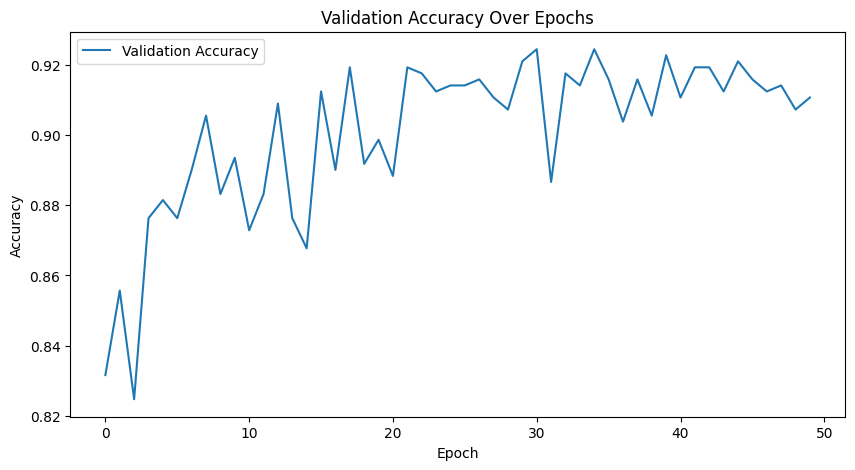

In [ ]:
# Plot the validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Print sentences with predicted and true emojis
for ix in range(embedding_matrix_test.shape[0]):
    if pred[ix] != np.argmax(Y_test[ix]):
        print(ix)
        print(test[0][ix], end=" ")
        print(emoji.emojize(emoji_dict[pred[ix]], language='alias'))
        # print(emoji.emojize(emoji_dict[np.argmax(Y_test[ix])], language='alias'))


3
she got me a present	 😄
6
I am upset	 😞
7
We had such a lovely dinner tonight	 🍴
20
I love taking breaks	 😞
29
valentine day is near	 😄
34
will you be my valentine	 😄
41
I like your jacket 	 ❤️
45
I love to the stars and back	 😄
49
go away	 ⚾
55
I did not have breakfast  🍴
59
She brought me a lovely gift	 😄
63
We had a great time at the party	 😄
68
She's not being nice	 😄
69
That was a great play	 ⚾
76
I enjoy relaxing on weekends	 😄
77
You're such a kind person	 ❤️
79
She's being so mean	 ❤️
90
Will you be my friend	 😞
96
Let's go out for fun	 ⚾
101
You're amazing	 ❤️
103
Let's have some fun	 ⚾
107
You're not doing well	 ❤️
117
I enjoyed our dinner date	 🍴
128
Stop being so dramatic	 😄
136
I had to work through the night	 😄
138
Have a restful break	 ❤️
139
Summer is almost here	 😄
142
I'm feeling really bored	 ❤️
150
Lets hang out soon	 😞
157
I want to make a joke	 ❤️
167
I am proud of your progress	 ❤️
175
You deserve this win	 ⚾
178
Let's catch up soon	 ⚾
184
I like your shoes	 ❤️

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion Matrix
[[ 53   0  10   4   4]
 [  0  28   0   0   0]
 [ 15   5 279   1   0]
 [  3   2   5 123   1]
 [  0   0   0   2  47]]
Confusion matrix, without normalization


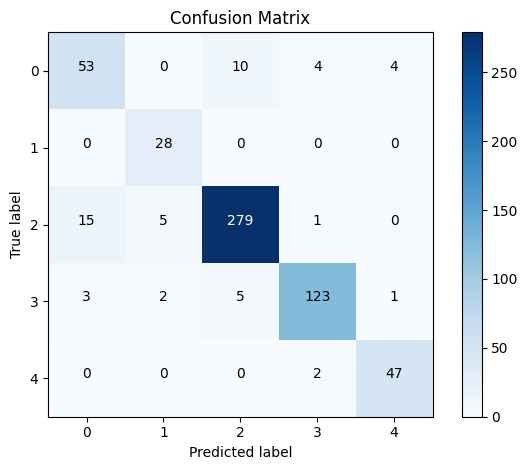

In [ ]:

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), pred)
print("Confusion Matrix")
print(conf_matrix)
plot_confusion_matrix(conf_matrix, classes=[0, 1, 2, 3, 4], title="Confusion Matrix")

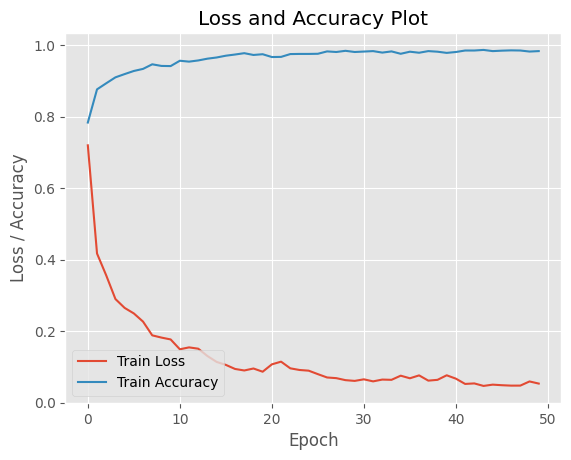

In [ ]:
# Plot Loss and Accuracy
epochs = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), hist.history["loss"], label="Train Loss")
plt.plot(np.arange(0, epochs), hist.history["accuracy"], label="Train Accuracy")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_bi.jpg")

In [ ]:
# Function to preprocess a given sentence and predict the emoji
def predict_emoji(sentence, model, word2vec_model, max_len=15, embedding_dim=300):
    # Convert sentence to embedding matrix
    words = sentence.lower().split()
    embedding_matrix = np.zeros((1, max_len, embedding_dim))

    for ix, word in enumerate(words):
        if ix >= max_len:
            break
        if word in word2vec_model:
            embedding_matrix[0, ix] = word2vec_model[word]
        else:
            print(f"Word '{word}' not found in Word2Vec model.")

    # Predict the emoji for the input sentence
    pred_prob = model.predict(embedding_matrix)
    predicted_emoji = np.argmax(pred_prob)

    return emoji.emojize(emoji_dict[predicted_emoji], language='alias')


In [ ]:
# Example input sentence
input_sentence = "i want something to eat"

# Predict the emoji for the input sentence
predicted_emoji = predict_emoji(input_sentence, lstm_model, word2vec_model)

# Display the result
print(f"Input Sentence: {input_sentence}")
print(f"Predicted Emoji: {predicted_emoji}")

Word 'to' not found in Word2Vec model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input Sentence: i want something to eat
Predicted Emoji: 🍴
